## Faster RCNN Demo

### DATASET
https://universe.roboflow.com/comp-776/comp776_final_project_fulldataset/dataset/2

In [ ]:
# ! Important !

# Set Model_training = True for model training.

# To to use a pretrained model,
# set Model_training = False and run all.

Model_training = False

In [ ]:
# uncomment this for the first run
!pip install boxx > .null

In [ ]:
import boxx  
# boxx: A Tool-box for Efficient Build and Debug in Python. Especially for Scientific Computing and Computer Vision.
# For more infomation about boxx : https://github.com/DIYer22/boxx
import numpy as np
import pandas as pd 
import random
import os
import math
import glob
import io

In [ ]:
import numpy as np
from PIL import Image, ImageDraw, ImageFont
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import torch 
import torchvision
from torchvision import transforms as T
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchmetrics.detection.mean_ap import MeanAveragePrecision
import cv2

In [ ]:
# activate this cell for the first run
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="f6HViwpNMpUya4uV10ay")
project = rf.workspace("comp-776").project("comp776_final_project_fulldataset")
dataset = project.version(2).download('coco',location="../data")

import shutil
        
os.makedirs('../data/annotations/train/', exist_ok=True)
os.makedirs('../data/annotations/valid/', exist_ok=True)
os.makedirs('../data/annotations/test/', exist_ok=True)

shutil.move('../data/train/_annotations.coco.json', '../data/annotations/train/_annotations.coco.json')
shutil.move('../data/valid/_annotations.coco.json', '../data/annotations/valid/_annotations.coco.json')
shutil.move('../data/test/_annotations.coco.json', '../data/annotations/test/_annotations.coco.json')

In [ ]:
print(os.listdir("../data/"))

['README.dataset.txt', 'README.roboflow.txt', 'test', 'train', 'valid', 'annotations']


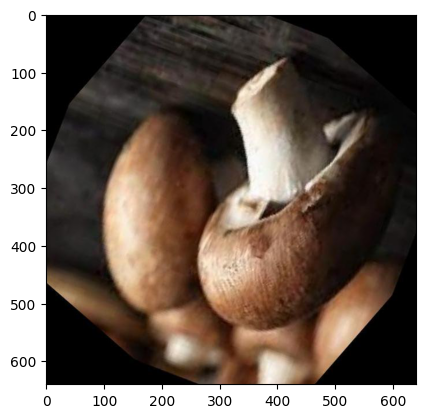

In [ ]:
# visualization train image (single image)
import glob
from skimage.io import imread
train_image = imread(glob.glob("../data/train/*")[0])
boxx.show(train_image)

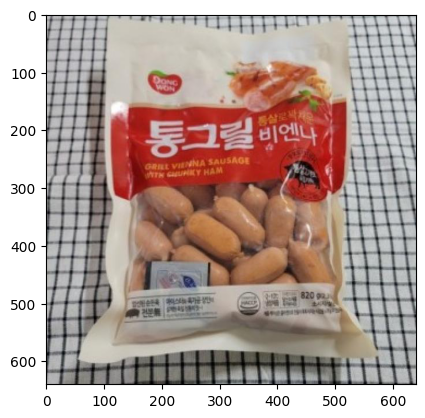

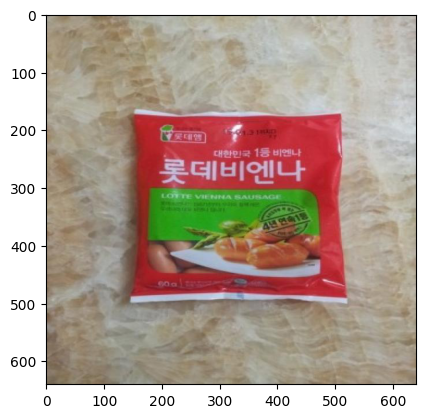

In [ ]:
# visualization test/val image (checkout image)
val_image = imread(glob.glob("../data/valid/*")[0])
boxx.show(val_image)

test_image = imread(glob.glob("../data/test/*")[0])
boxx.show(test_image)

In [ ]:
# Loading annotation files
train_js = boxx.loadjson('../data/annotations/train/_annotations.coco.json')
valid_js = boxx.loadjson('../data/annotations/valid/_annotations.coco.json')
test_js = boxx.loadjson('../data/annotations/test/_annotations.coco.json')

# Visualization struct of train
# These annotation files has similar struct as COCO Object Detection Dataset
boxx.tree(train_js, deep=1)

└── /: dict  5
    ├── info: dict  6
    ├── licenses: list  1
    ├── categories: list  26
    ├── images: list  13486
    └── annotations: list  50376


In [ ]:
boxx.tree(valid_js, deep=1)

└── /: dict  5
    ├── info: dict  6
    ├── licenses: list  1
    ├── categories: list  26
    ├── images: list  2019
    └── annotations: list  3727


In [ ]:
boxx.tree(test_js, deep=1)

└── /: dict  5
    ├── info: dict  6
    ├── licenses: list  1
    ├── categories: list  26
    ├── images: list  929
    └── annotations: list  2103


In [ ]:
train_js.keys()  # values of these keys can be converted into dataframe

dict_keys(['info', 'licenses', 'categories', 'images', 'annotations'])

In [ ]:
# Visualization struct of images
from pprint import pprint
pprint(train_js['images'][0])

{'date_captured': '2023-05-03T03:24:19+00:00',
 'file_name': '1024_jpg.rf.6380174193f05ff026ff2f2a86804600.jpg',
 'height': 640,
 'id': 0,
 'license': 1,
 'width': 640}


In [ ]:
# Visualization struct of annotations
pprint(train_js['annotations'][0])

{'area': 120600,
 'bbox': [198, 0, 335, 360],
 'category_id': 4,
 'id': 0,
 'image_id': 0,
 'iscrowd': 0,
 'segmentation': []}


In [ ]:
# The Categories Data format
train_categories_df = pd.DataFrame(train_js['categories'])
valid_categories_df = pd.DataFrame(valid_js['categories'])
test_categories_df = pd.DataFrame(test_js['categories'])
#train_categories_df.to_excel("categories_df.xlsx")
train_categories_df

,id,name,supercategory
0,0,Food-Ingredients,none
1,1,apple,Food-Ingredients
2,2,banana,Food-Ingredients
3,3,beef,Food-Ingredients
4,4,bell pepper,Food-Ingredients
5,5,bread,Food-Ingredients
6,6,cabbage,Food-Ingredients
7,7,carrot,Food-Ingredients
8,8,chicken,Food-Ingredients
9,9,egg,Food-Ingredients


In [ ]:
train_categories_df['name'].unique(), train_categories_df['name'].unique().shape

(array(['Food-Ingredients', 'apple', 'banana', 'beef', 'bell pepper',
        'bread', 'cabbage', 'carrot', 'chicken', 'egg', 'eggplant',
        'garlic', 'leek', 'lettuce', 'mushroom', 'onion', 'orange', 'pork',
        'potato', 'radish', 'red pepper', 'rice', 'sausage', 'tofu',
        'tomato', 'zucchini'], dtype=object),
 (26,))

In [ ]:
train_annotations_df = pd.DataFrame(train_js['annotations'])
train_annotations_df

,id,image_id,category_id,bbox,area,segmentation,iscrowd
0,0,0,4,"[198, 0, 335, 360]",120600.0,[],0
1,1,0,4,"[91, 364, 239, 263]",62857.0,[],0
2,2,0,4,"[276, 404, 229, 171]",39159.0,[],0
3,3,0,4,"[295, 277, 241, 176]",42416.0,[],0
4,4,0,4,"[0, 273, 155, 212]",32860.0,[],0
...,...,...,...,...,...,...,...
50371,50371,13484,9,"[240, 380, 93, 197]",18321.0,[],0
50372,50372,13485,6,"[283, 332, 357, 308]",109956.0,[],0
50373,50373,13485,6,"[241, 96, 393, 227]",89211.0,[],0
50374,50374,13485,6,"[5, 330, 286, 310]",88660.0,[],0


In [ ]:
valid_annotations_df = pd.DataFrame(valid_js['annotations'])
valid_annotations_df

,id,image_id,category_id,bbox,area,segmentation,iscrowd
0,0,0,19,"[189, 52, 401.5, 426]",171039.00,[],0
1,1,1,23,"[235, 345, 58, 70]",4060.00,[],0
2,2,2,10,"[202, 0, 229, 638]",146102.00,[],0
3,3,3,3,"[66, 0, 495.5, 638.5]",316376.75,[],0
4,4,4,24,"[175, 0, 306, 352]",107712.00,[],0
...,...,...,...,...,...,...,...
3722,3722,2017,24,"[8, 28, 630.5, 604.5]",381137.25,[],0
3723,3723,2018,9,"[366, 187, 197.5, 278.5]",55003.75,[],0
3724,3724,2018,9,"[334, 180, 126.5, 245.5]",31055.75,[],0
3725,3725,2018,9,"[204, 188, 199.5, 344.5]",68727.75,[],0


In [ ]:
test_annotations_df = pd.DataFrame(test_js['annotations'])
test_annotations_df

,id,image_id,category_id,bbox,area,segmentation,iscrowd
0,0,0,16,"[231, 14, 163, 155.5]",25346.50,[],0
1,1,0,16,"[225, 137, 172.5, 189]",32602.50,[],0
2,2,0,16,"[189, 297, 241.5, 341.5]",82472.25,[],0
3,3,1,25,"[169, 0, 310, 638]",197780.00,[],0
4,4,2,17,"[51, 0, 526, 638.5]",335851.00,[],0
...,...,...,...,...,...,...,...
2098,2098,927,2,"[19, 38, 518, 423.5]",219373.00,[],0
2099,2099,927,2,"[114, 75, 434, 527]",228718.00,[],0
2100,2100,928,8,"[202, 174, 433, 336.5]",145704.50,[],0
2101,2101,928,8,"[64, 82, 393, 493.5]",193945.50,[],0


In [ ]:
train_js_images = pd.DataFrame(train_js['images'])
train_js_images

,id,license,file_name,height,width,date_captured
0,0,1,1024_jpg.rf.6380174193f05ff026ff2f2a86804600.jpg,640,640,2023-05-03T03:24:19+00:00
1,1,1,istockphoto-855337612-612x612_jpg.rf.63818e34f...,640,640,2023-05-03T03:24:19+00:00
2,2,1,A260115_50621_jpg.rf.6381aee890e48e21616975808...,640,640,2023-05-03T03:24:19+00:00
3,3,1,istockphoto-480569383-612x612_jpg.rf.6382fdad6...,640,640,2023-05-03T03:24:19+00:00
4,4,1,istockphoto-178797344-612x612_jpg.rf.638386645...,640,640,2023-05-03T03:24:19+00:00
...,...,...,...,...,...,...
13481,13481,1,rotated_by_15_Screen-Shot-2018-06-12-at-11-54-...,640,640,2023-05-03T03:24:19+00:00
13482,13482,1,istockphoto-509538164-612x612_jpg.rf.b0b733f4d...,640,640,2023-05-03T03:24:19+00:00
13483,13483,1,istockphoto-153560601-612x612_jpg.rf.b0a8ca648...,640,640,2023-05-03T03:24:19+00:00
13484,13484,1,istockphoto-1257345744-612x612_jpg.rf.b098e562...,640,640,2023-05-03T03:24:19+00:00


In [ ]:
valid_js_images = pd.DataFrame(valid_js['images'])
valid_js_images

,id,license,file_name,height,width,date_captured
0,0,1,istockphoto-509362789-612x612_jpg.rf.005d3bc78...,640,640,2023-05-03T03:24:19+00:00
1,1,1,A250101XX_10499_jpg.rf.00356762696fc9ad519bee4...,640,640,2023-05-03T03:24:19+00:00
2,2,1,istockphoto-462405467-612x612_jpg.rf.005078459...,640,640,2023-05-03T03:24:19+00:00
3,3,1,istockphoto-521535056-612x612_jpg.rf.017ce17d9...,640,640,2023-05-03T03:24:19+00:00
4,4,1,istockphoto-1154039165-612x612_jpg.rf.00b8e1a9...,640,640,2023-05-03T03:24:19+00:00
...,...,...,...,...,...,...
2014,2014,1,istockphoto-810602596-612x612_jpg.rf.ff1686107...,640,640,2023-05-03T03:24:19+00:00
2015,2015,1,istockphoto-89467495-612x612_jpg.rf.fb76df0f4a...,640,640,2023-05-03T03:24:19+00:00
2016,2016,1,istockphoto-821741540-612x612_jpg.rf.fdae9ecc4...,640,640,2023-05-03T03:24:19+00:00
2017,2017,1,istockphoto-1190223996-612x612_jpg.rf.ff404360...,640,640,2023-05-03T03:24:19+00:00


In [ ]:
test_js_images = pd.DataFrame(test_js['images'])
test_js_images

,id,license,file_name,height,width,date_captured
0,0,1,download5_jpg.rf.0110b68c2deaf73f72311c5c12b22...,640,640,2023-05-03T03:24:19+00:00
1,1,1,istockphoto-112805472-612x612_jpg.rf.01452d0ed...,640,640,2023-05-03T03:24:19+00:00
2,2,1,istockphoto-1257693769-612x612_jpg.rf.0147e0ab...,640,640,2023-05-03T03:24:19+00:00
3,3,1,istockphoto-120873417-612x612_jpg.rf.0153f460e...,640,640,2023-05-03T03:24:19+00:00
4,4,1,istockphoto-818558680-612x612_jpg.rf.00981ab31...,640,640,2023-05-03T03:24:19+00:00
...,...,...,...,...,...,...
924,924,1,istockphoto-471438145-612x612_jpg.rf.fb781262a...,640,640,2023-05-03T03:24:19+00:00
925,925,1,istockphoto-645426434-612x612_jpg.rf.ff8be4d2f...,640,640,2023-05-03T03:24:19+00:00
926,926,1,istockphoto-626500680-612x612_jpg.rf.ffe271fbc...,640,640,2023-05-03T03:24:19+00:00
927,927,1,banana19_jpg.rf.ffc4901442619efb8aad9df24aa823...,640,640,2023-05-03T03:24:19+00:00


In [ ]:
# select smaller subset check for errors. Reset index for correct concatenation
#train_annotations_df = train_annotations_df[::20].reset_index(drop=True)
#valid_annotations_df = valid_annotations_df[::20].reset_index(drop=True)
#test_annotations_df = test_annotations_df[::20].reset_index(drop=True)

# for full dataset run below
train_annotations_df = train_annotations_df.reset_index(drop=True)
valid_annotations_df = valid_annotations_df.reset_index(drop=True)
test_annotations_df = test_annotations_df.reset_index(drop=True)

In [ ]:
# if bbox column is in diffrent format, use lambda function to convert to standard coco format: ["x1", "y1", "w", "h"]
# coords = pd.DataFrame(list(train_annotations_df.bbox.apply(lambda x: x).values),columns=["x1", "y1", "w", "h"])
# otherwise use values directly
train_coords = pd.DataFrame(list(train_annotations_df.bbox.values),columns=["x1", "y1", "w", "h"])
valid_coords = pd.DataFrame(list(valid_annotations_df.bbox.values),columns=["x1", "y1", "w", "h"])
test_coords = pd.DataFrame(list(test_annotations_df.bbox.values),columns=["x1", "y1", "w", "h"])

In [ ]:
train_df = pd.concat([train_annotations_df, train_coords], axis=1)
valid_df = pd.concat([valid_annotations_df, valid_coords], axis=1)
test_df = pd.concat([test_annotations_df, test_coords], axis=1)

In [ ]:
train_df["x2"] = train_df["x1"] + train_df["w"]
train_df["y2"] = train_df["y1"] + train_df["h"]
valid_df["x2"] = valid_df["x1"] + valid_df["w"]
valid_df["y2"] = valid_df["y1"] + valid_df["h"]
test_df["x2"] = test_df["x1"] + test_df["w"]
test_df["y2"] = test_df["y1"] + test_df["h"]

In [ ]:
train_df

,id,image_id,category_id,bbox,area,segmentation,iscrowd,x1,y1,w,h,x2,y2
0,0,0,4,"[198, 0, 335, 360]",120600.0,[],0,198,0,335.0,360.0,533.0,360.0
1,1,0,4,"[91, 364, 239, 263]",62857.0,[],0,91,364,239.0,263.0,330.0,627.0
2,2,0,4,"[276, 404, 229, 171]",39159.0,[],0,276,404,229.0,171.0,505.0,575.0
3,3,0,4,"[295, 277, 241, 176]",42416.0,[],0,295,277,241.0,176.0,536.0,453.0
4,4,0,4,"[0, 273, 155, 212]",32860.0,[],0,0,273,155.0,212.0,155.0,485.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
50371,50371,13484,9,"[240, 380, 93, 197]",18321.0,[],0,240,380,93.0,197.0,333.0,577.0
50372,50372,13485,6,"[283, 332, 357, 308]",109956.0,[],0,283,332,357.0,308.0,640.0,640.0
50373,50373,13485,6,"[241, 96, 393, 227]",89211.0,[],0,241,96,393.0,227.0,634.0,323.0
50374,50374,13485,6,"[5, 330, 286, 310]",88660.0,[],0,5,330,286.0,310.0,291.0,640.0


In [ ]:
train_df.drop(["bbox", "area", 'segmentation', "w", "h", 'iscrowd'], axis=1, inplace=True)
valid_df.drop(["bbox", "area", 'segmentation', "w", "h", 'iscrowd'], axis=1, inplace=True)
test_df.drop(["bbox", "area", 'segmentation', "w", "h", 'iscrowd'], axis=1, inplace=True)

In [ ]:
train_df

,id,image_id,category_id,x1,y1,x2,y2
0,0,0,4,198,0,533.0,360.0
1,1,0,4,91,364,330.0,627.0
2,2,0,4,276,404,505.0,575.0
3,3,0,4,295,277,536.0,453.0
4,4,0,4,0,273,155.0,485.0
...,...,...,...,...,...,...,...
50371,50371,13484,9,240,380,333.0,577.0
50372,50372,13485,6,283,332,640.0,640.0
50373,50373,13485,6,241,96,634.0,323.0
50374,50374,13485,6,5,330,291.0,640.0


In [ ]:
class CustomDataset(torch.utils.data.Dataset):
    #def __init__(self, df, unique_imgs, indices, category_id):
    def __init__(self, df, mode='train'):
        self.df = df
        self.unique_imgs = df.image_id.unique()
        self.indices = self.unique_imgs
        self.category_id = df.category_id.values
        self.mode = mode
    def __len__ (self):
        return len(self.indices)
    def __getitem__(self, idx):
        img_id = self.unique_imgs[idx]
        #img_id = int(img_id)
        boxes = self.df[self.df.image_id == img_id].values[:,3:]#.astype("float")
        #img = Image.open("../data/train2019/*")[idx].convert('RGB')
        img = Image.open(glob.glob("../data/"+self.mode+"/*")[img_id]).convert('RGB')
        #labels = self.category_id[self.df.image_id == img_id].values#.astype("float")

        #print('BOXES',boxes.shape[0])
        labels = self.df[self.df.image_id == img_id].values[:,2]
        labels = torch.tensor(labels,dtype=torch.int64)
        #print('LABELS',len(labels))
        
        #labels = torch.tensor(category_id.values)
        target = {}
        target["boxes"] = torch.tensor(boxes,dtype=torch.float32)
        target["labels"] = labels
        return T.ToTensor()(img), target

In [ ]:
def custom_collate(data):
    return data

In [ ]:
train_dl = torch.utils.data.DataLoader(CustomDataset(train_df, mode='train'),
                                       batch_size = 20,
                                       shuffle = True,
                                       collate_fn = custom_collate,
                                       pin_memory = True if torch.backends.mps.is_available() else False)

valid_dl = torch.utils.data.DataLoader(CustomDataset(valid_df, mode='valid'),
                                       batch_size = 5,
                                       shuffle = True,
                                       collate_fn = custom_collate,
                                       pin_memory = True if torch.backends.mps.is_available() else False)

test_dl = torch.utils.data.DataLoader(CustomDataset(test_df, mode='test'),
                                       batch_size = 5,
                                       shuffle = True,
                                       collate_fn = custom_collate,
                                       pin_memory = True if torch.backends.mps.is_available() else False)

In [ ]:
train_category_id = train_df.category_id
valid_category_id = valid_df.category_id
test_category_id = test_df.category_id


In [ ]:
train_labels = train_category_id.unique()
sorted(train_labels), train_labels.shape

([1, 2, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20, 21, 22, 23, 25],
 (21,))

In [ ]:
valid_labels = valid_category_id.unique()
sorted(valid_labels), valid_labels.shape

([1, 2, 3, 5, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 21, 22, 23, 24, 25],
 (21,))

In [ ]:
test_labels = test_category_id.unique()
sorted(test_labels), test_labels.shape

([1, 2, 3, 7, 8, 9, 10, 13, 15, 16, 17, 18, 19, 21, 22, 24, 25], (17,))

In [ ]:
labels = train_categories_df.id.values
labels

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25])

In [ ]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretranined=True)
num_classes = len(labels) + 1 # one more for background
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [ ]:
available_gpus = [torch.cuda.device(i) for i in range(torch.cuda.device_count())]
for gpu in available_gpus:
    print(torch.cuda.get_device_name(device=gpu))

TITAN RTX
TITAN RTX
GeForce RTX 2080 Ti
GeForce RTX 2080 Ti


In [ ]:
# select between cpu and gpu
#device = torch.device('cpu') # for cpu usage
device = torch.device('cuda:1' if torch.cuda.is_available() else ('mps' if torch.backends.mps.is_available() else 'cpu'))

In [ ]:
print(f'device:{device} | mps_available:{torch.backends.mps.is_available()} | cuda_available:{torch.cuda.is_available()}')

device:cuda:1 | mps_available:False | cuda_available:True


In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0005)
num_epochs = 20

In [ ]:
model.to(device)

if Model_training:
    loss_epoch = []
    loss_batch = []

    for epoch in range(num_epochs):
        epoch_loss = 0
        print(f'** Epoch: {epoch+1}|{num_epochs} **')
        print(f'  Number of batches: {len(train_dl)}')
        for data in tqdm(train_dl):
            imgs = []
            targets = []
            for d in data:
                imgs.append(d[0].to(device))
                targ = {}
                targ["boxes"] = d[1]["boxes"].to(device)
                targ["labels"] = d[1]["labels"].to(device)
                targets.append(targ)
            loss_dict = model(imgs, targets)
            loss = sum(v for v in loss_dict.values())
            epoch_loss += loss.cpu().detach().numpy()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_batch.append(epoch_loss)
        loss_epoch.append(epoch_loss)
        print('  Epoch loss: ',epoch_loss)
        model_path = 'model_'+str(epoch+1)+'epochs.pt'
        torch.save(model.state_dict(), model_path)
    model.to(torch.device('cpu'))
    torch.save(model.state_dict(), 'model_fasterrcnn_1.pt')
    
    plt.plot(loss_batch, label='loss_batch')
    plt.grid()
    plt.show()
    plt.plot(loss_epoch,label='loss_epoch')
    plt.legend()
    plt.grid()
    plt.show()
    
else:
    model.load_state_dict(torch.load('model_fasterrcnn.pt'))
    model.eval()

In [ ]:
#train_categories_df.to_csv("train_categories_df.csv")

In [ ]:
# Validation scores. Use for hyperparameter tuning.
model.eval()
with torch.no_grad():
    target = []
    preds = []
    for data in tqdm(valid_dl):
        for i in range(len(data)):

            img = data[i][0]
            output = model([img.to(device)])
            img.cpu().detach()
            output[0]['boxes'] = output[0]['boxes'].cpu().detach()
            output[0]['labels'] = output[0]['labels'].cpu().detach()
            target.append(data[i][1])
            preds.append(output[0])

metric = MeanAveragePrecision()
metric.update(preds, target)
map_score_valid = metric.compute()

100%|█████████████████████████████████████████| 404/404 [01:39<00:00,  4.05it/s]


In [ ]:
print('Mean Average Precision Scores (Validation):')
pd.DataFrame(map_score_valid,index=[0]).T

Mean Average Precision Scores (Validation):


,0
map,tensor(0.0017)
map_50,tensor(0.0039)
map_75,tensor(0.0016)
map_small,tensor(0.)
map_medium,tensor(0.)
map_large,tensor(0.0017)
mar_1,tensor(0.0818)
mar_10,tensor(0.0899)
mar_100,tensor(0.0899)
mar_small,tensor(0.)


In [ ]:
# Test scores.
model.eval()
with torch.no_grad():
    target = []
    preds = []

    for data in tqdm(test_dl):
        for i in range(len(data)):

            img = data[i][0]
            output = model([img.to(torch.device('cuda:1'))])
            output[0]['boxes'] = output[0]['boxes'].cpu().detach()
            output[0]['labels'] = output[0]['labels'].cpu().detach()
            target.append(data[i][1])
            preds.append(output[0])

metric = MeanAveragePrecision()
metric.update(preds, target)
map_score_test = metric.compute()

100%|█████████████████████████████████████████| 186/186 [00:42<00:00,  4.36it/s]


In [ ]:
print('Mean Average Precision Scores (Test):')
pd.DataFrame(map_score_test,index=[0]).T

Mean Average Precision Scores (Test):


,0
map,tensor(0.0023)
map_50,tensor(0.0060)
map_75,tensor(0.0018)
map_small,tensor(0.)
map_medium,tensor(0.)
map_large,tensor(0.0024)
mar_1,tensor(0.0774)
mar_10,tensor(0.0815)
mar_100,tensor(0.0815)
mar_small,tensor(0.)


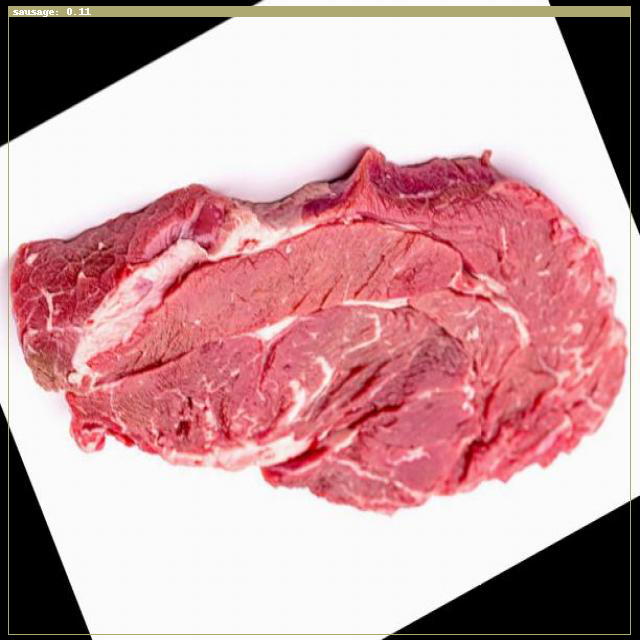

In [ ]:
model.eval()
with torch.no_grad():
    data = iter(test_dl).__next__()
    img = data[0][0]
    boxes = data[0][1]["boxes"]
    labels = data[0][1]["labels"]
    output = model([img.to(torch.device('cuda:1'))])
    output[0].keys(), len(output)
    out_bbox = output[0]['boxes']
    out_scores = output[0]['scores']
    out_labels = output[0]['labels']
    keep = torchvision.ops.nms(out_bbox, out_scores, 0.15)
    out_bbox = out_bbox[keep]
    out_scores = out_scores[keep]
    out_labels = out_labels[keep]
    out_labels_cpu = out_labels.cpu().detach().numpy()
    out_labels_df = pd.DataFrame(out_labels_cpu,columns=['labels'])
    out_classes = pd.DataFrame(list(out_labels_df.labels.apply(lambda x: train_categories_df.name[x])),columns=["category"])
    im = (img.permute(1,2,0).cpu().detach().numpy() * 255).astype('uint8')

# image and bboxes with labels
import random

def random_color():
    return (random.randint(0,255), random.randint(0,255),random.randint(0,255)) 

vsample = Image.fromarray(im)
draw = ImageDraw.Draw(vsample)
for b in range(len(out_bbox)):
    box = out_bbox[b]
    color = random_color()
    draw.rectangle(list(box), fill=None, outline=color)
    text = out_classes.category[b]
    box_score = str(round(out_scores[b].detach().cpu().item(),2))
    # drawing text size
    draw.rectangle((box[0], box[1],box[2],box[1]+10), fill=color)
    draw.text((box[0]+5, box[1]), text+': '+box_score, fill='white', align="right")   
vsample